In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
import os
import mne
from mne.io import concatenate_raws, read_raw_edf
import json
import scipy.io
import pandas as pd
from pandas import read_excel
from scipy.sparse import hstack

## Loading Data 

In [2]:
raw = mne.io.read_raw_edf('07011905_2019.07.01_16.03.51.edf',preload=True)
# print(raw)
# print(raw.info)

Extracting EDF parameters from /Users/avishagaur/Documents/Project arjun/EEG/EMOTIV/Subject 1/32/07011905_2019.07.01_16.03.51.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75263  =      0.000 ...   587.992 secs...


## Markers Data

In [3]:
event_markers = pd.read_excel('07011905_2019.07.01_16.03.51.xlsx')
event_ids = [1,2,3,4,5]
event_keys = {"EyesOpenedStart":1, "EyesOpenedEnd":2, "EyesClosedStart":3, "EyesClosedEnd":4, 
              "PenaltyKickTrial":5}
onset = event_markers["time"]
index = event_markers["marker"]
# print(event_markers)

# Pre-processing

### Pick 32 channels 

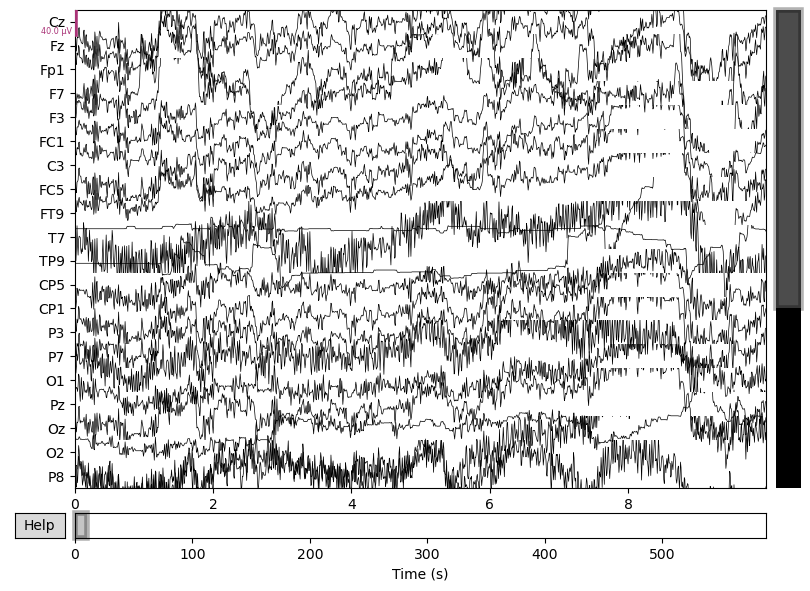

In [4]:
# print(raw.info['ch_names']) 
eeg_ch_names = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'TP9', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Pz', 'Oz', 'O2', 'P8', 'P4', 'CP2', 'CP6', 'TP10', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
picks = mne.pick_channels(raw.info["ch_names"], eeg_ch_names)
# print(picks)
pick_raw = raw.copy().pick_channels(eeg_ch_names)
pick_raw.plot()


### Re-referencing with average of all channels

In [5]:
pick_avg_ref, array = mne.set_eeg_reference(pick_raw, ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


### Re-referenced data plot

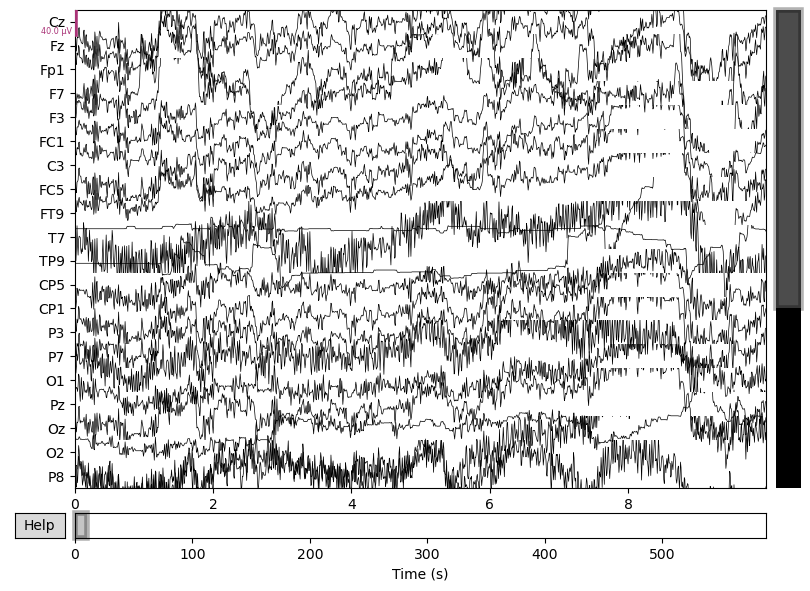

In [6]:
#used preload = True above so that data can be loaded to plot here
pick_raw.plot()

## Filtering 

### FIR band pass filtering (0.1, 45)Hz

In [7]:
l_freq = 0.1
h_freq = 45
filter_pick_avg_ref = pick_avg_ref.filter(l_freq, h_freq, picks=None, filter_length='auto', 
                                        l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                        n_jobs=1, method='fir', iir_params=None, phase='zero', 
                                        fir_window='hamming', fir_design='firwin', 
                                        pad='reflect_limited', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)



### plot filtered data

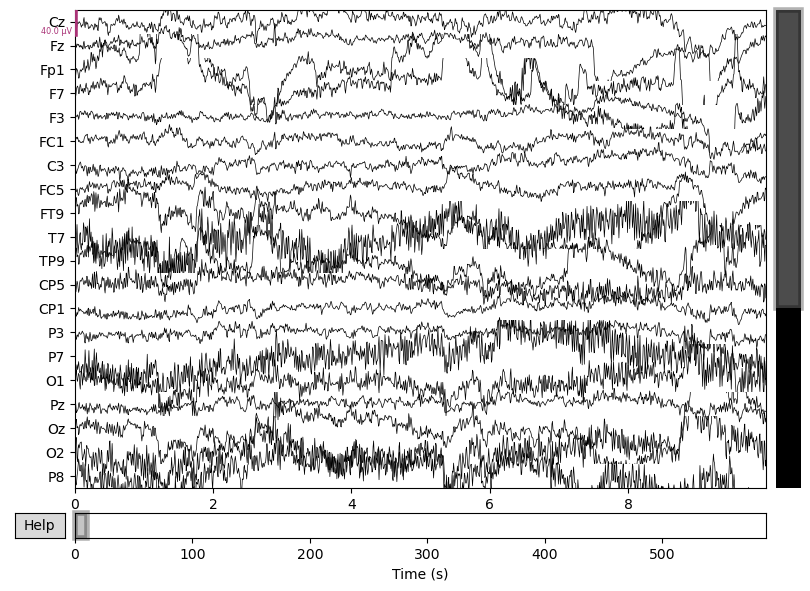

In [8]:
filter_pick_avg_ref.plot()

### Notch filter 60 Hz

In [9]:
freqs = 60
notch_filter_pick_avg_ref = filter_pick_avg_ref.notch_filter(freqs, picks=None, filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=1, method='fir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', verbose=None)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)



### plot notch-filtered data

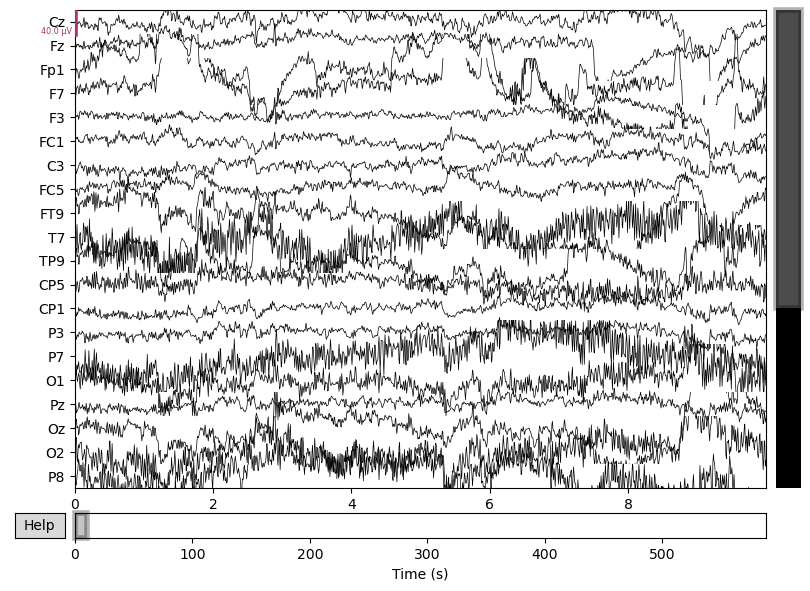

In [10]:
notch_filter_pick_avg_ref.plot()

## Fit data to montage

In [11]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
ten_twenty_montage.plot(kind='topomap', show_names=True)
notch_filter_pick_avg_ref.set_montage(ten_twenty_montage)

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<RawEDF | 07011905_2019.07.01_16.03.51.edf, 32 x 75264 (588.0 s), ~18.4 MB, data loaded>

In [12]:
raw_1020 = pick_raw.copy().set_montage(ten_twenty_montage)
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
raw_1020.plot_sensors(ch_type='eeg', axes=ax2d, show_names=True)
raw_1020.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d', show_names=True)
ax3d.view_init(azim=70, elev=15)



# ICA

## Fit to ICA

In [13]:
from mne.preprocessing import ICA
ica = ICA(n_components = 31, random_state=97)
ica.fit(notch_filter_pick_avg_ref)

Fitting ICA to data using 32 channels (please be patient, this may take a while)


<ipython-input-13-3202130d8f4b>:2: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components = 31, random_state=97)


Selecting by number: 31 components
Fitting ICA took 5.2s.


<ICA | raw data decomposition, fit (fastica): 75264 samples, 31 components, channels used: "eeg">

## plot raw data sources (32 comp)

Creating RawArray with float64 data, n_channels=31, n_times=75264
    Range : 0 ... 75263 =      0.000 ...   587.992 secs
Ready.


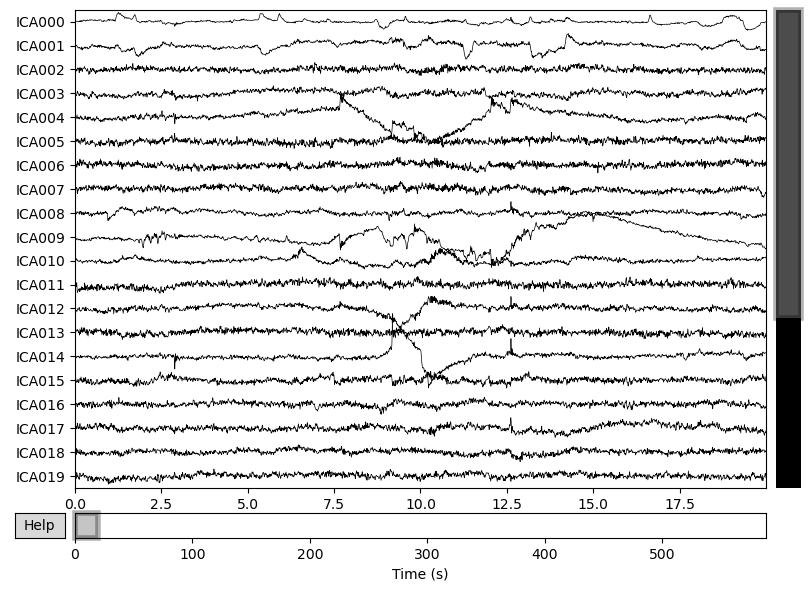

Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none


In [14]:
raw.load_data()
ica.plot_sources(notch_filter_pick_avg_ref)

In [17]:
# electrode i -> picks = i
ica.plot_properties(notch_filter_pick_avg_ref, picks = 0)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>]

## plot ICA fitted comp.

In [16]:
ica.plot_components()

[<MNEFigure size 975x775 with 20 Axes>, <MNEFigure size 975x731 with 11 Axes>]

### Exclude artifacts

In [80]:
ica.exclude = [0, 1, 2, 16, 19, 25, 26]

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components


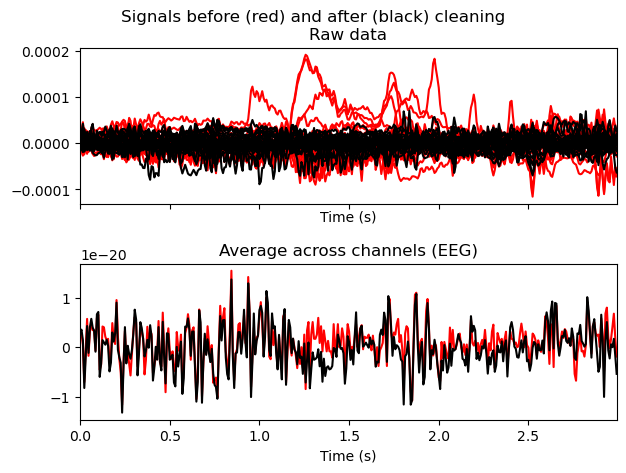

In [81]:
ica.plot_overlay(notch_filter_pick_avg_ref)

### Reconstruct after excluding

In [82]:
reconst_raw = notch_filter_pick_avg_ref.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components


<RawEDF | 07011905_2019.07.01_16.03.51.edf, 32 x 75264 (588.0 s), ~18.4 MB, data loaded>

## Comparison 

### Before ICA

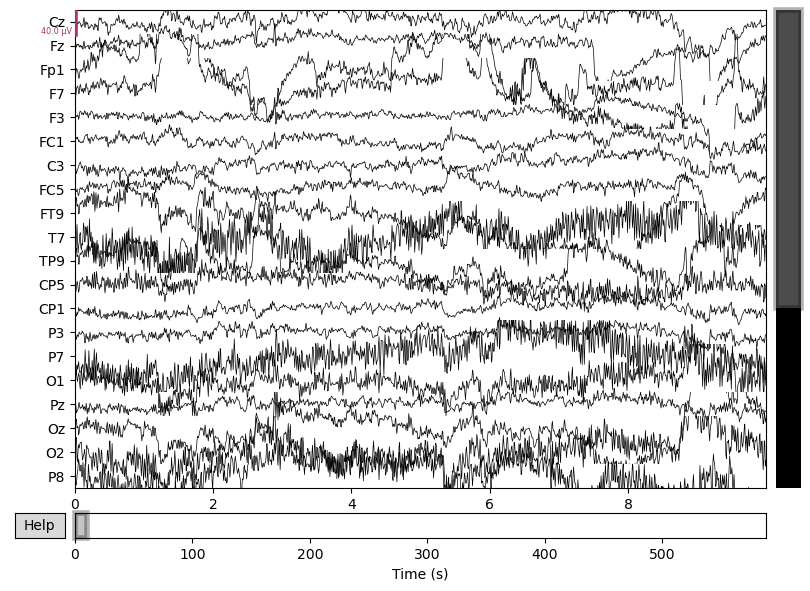

In [83]:
notch_filter_pick_avg_ref.plot()

### After ICA

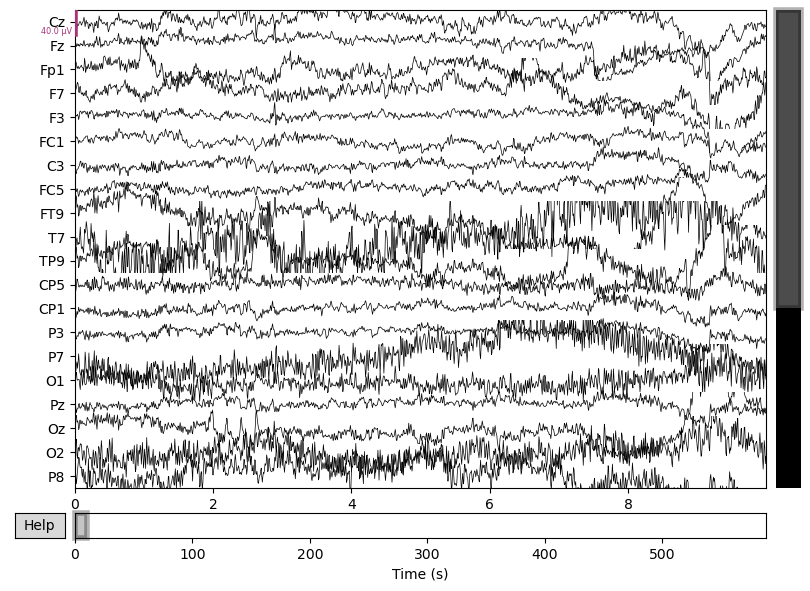

Channels marked as bad: none
Channels marked as bad: none


In [84]:
reconst_raw.plot()

## Filtering again 

In [85]:
l_freq = 0.1
h_freq = 45
filter_reconst = reconst_raw.filter(l_freq, h_freq, picks=None, filter_length='auto', 
                                        l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                        n_jobs=1, method='fir', iir_params=None, phase='zero', 
                                        fir_window='hamming', fir_design='firwin', 
                                        pad='reflect_limited', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)



In [86]:
reconst = filter_reconst.plot()

Channels marked as bad: none


# Epoching data

## based on pkevents.mat excel sheet for this subject

In [93]:
# print(event_markers)
events = np.array(event_markers[["latency","marker","marker"]])
epochs = mne.Epochs(filter_reconst, events, event_id = event_ids, tmin = - 0.5, tmax = 3, baseline=None, picks=None, 
                    preload=False, reject=None, flat=None, proj=True, decim=1, reject_tmin=None, 
                    reject_tmax=None, detrend=None, on_missing='warning', reject_by_annotation=True, 
                    metadata=None, event_repeated='error', verbose=None)
# print(epochs)

Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated


Loading data for 54 events and 449 original time points ...
Loading data for 20 events and 449 original time points ...


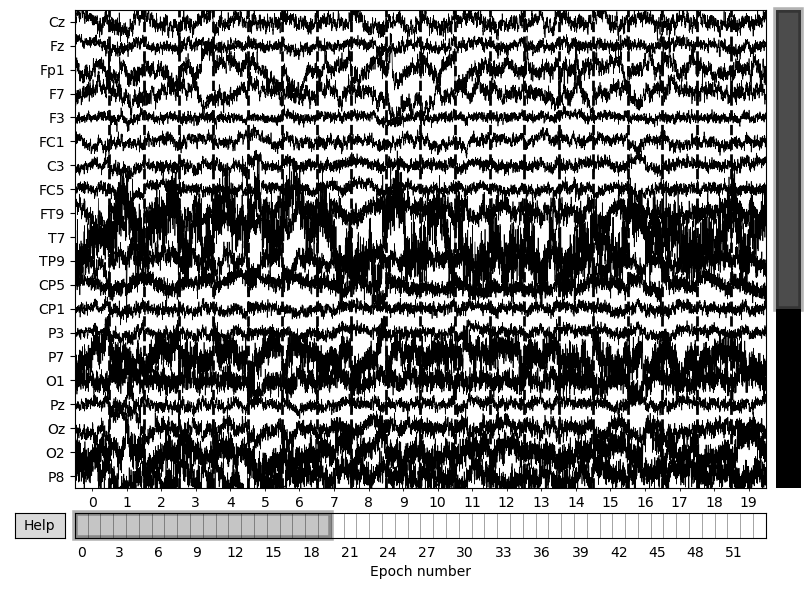

Loading data for 20 events and 449 original time points ...
Loading data for 20 events and 449 original time points ...
Loading data for 20 events and 449 original time points ...
Loading data for 20 events and 449 original time points ...
Loading data for 20 events and 449 original time points ...
Dropped 2 epochs: 25, 30
Channels marked as bad: none


In [95]:
epochs.plot()

# Band power analysis

In [96]:
EyesOpenedStart = epochs[0]
EyesOpenedEnd = epochs[1]
EyesClosedStart = epochs[2]
EyesClosedEnd = epochs[3]


In [97]:
from mne.time_frequency import psd_multitaper
n_fft = 2048


### Multitaper technique

In [98]:
def bandpower(data, sf, low, high, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    # Compute the modified periodogram (Welch)
    psd_total, freqs_total = psd_multitaper(data, low_bias=True, proj=True, n_jobs=1)
    psd, freqs = psd_multitaper(data, fmin=low, fmax=high, low_bias=True, proj=True, n_jobs=1)

    # Frequency resolution
    freq_res = freqs_total[1] - freqs_total[0]

    # Find index of band in frequency vector
    # idx_band = np.logical_and(psd[:,] >= low, psd[:,] <= high)
    
    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd, dx=freq_res)

    if relative:
        bp = simps(psd, dx=freq_res) / simps(psd_total, dx=freq_res)
    return bp

In [99]:
# band range 

sf = 128
delta_low = 0.5
delta_high = 4

theta_low = 4
theta_high = 8

alpha_low = 8
alpha_high = 12

beta_low = 12
beta_high = 30

In [100]:
# calculate bandpower 

bp_0_delta = bandpower(epochs[0], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
bp_0_theta = bandpower(epochs[0], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
bp_0_alpha = bandpower(epochs[0], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
bp_0_beta = bandpower(epochs[0], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

# bp_1_delta = bandpower(epochs[1], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
# bp_1_theta = bandpower(epochs[1], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
# bp_1_alpha = bandpower(epochs[1], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
# bp_1_beta = bandpower(epochs[1], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

bp_2_delta = bandpower(epochs[2], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
bp_2_theta = bandpower(epochs[2], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
bp_2_alpha = bandpower(epochs[2], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
bp_2_beta = bandpower(epochs[2], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

# bp_3_delta = bandpower(epochs[3], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
# bp_3_theta = bandpower(epochs[3], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
# bp_3_alpha = bandpower(epochs[3], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
# bp_3_beta = bandpower(epochs[3], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 

### Relative band power average over channels

In [101]:
print("Eyes Opened Start")
print("delta",np.average(bp_0_delta)*100,"%")
print("theta",np.average(bp_0_theta)*100,"%")
print("alpha",np.average(bp_0_alpha)*100,"%")
print("beta",np.average(bp_0_beta)*100,"%\n")

# print("Eyes Opened End")
# print("delta",np.average(bp_1_delta)*100,"%")
# print("theta",np.average(bp_1_theta)*100,"%")
# print("alpha",np.average(bp_1_alpha)*100,"%")
# print("beta",np.average(bp_1_beta)*100,"%\n")

print("Eyes Closed Start")
print("delta",np.average(bp_2_delta)*100,"%")
print("theta",np.average(bp_2_theta)*100,"%")
print("alpha",np.average(bp_2_alpha)*100,"%")
print("beta",np.average(bp_2_beta)*100,"%\n")

# print("Eyes Closed End")
# print("delta",np.average(bp_3_delta)*100,"%")
# print("theta",np.average(bp_3_theta)*100,"%")
# print("alpha",np.average(bp_3_alpha)*100,"%")
# print("beta",np.average(bp_3_beta)*100,"%")

Eyes Opened Start
delta 36.838575716583236 %
theta 8.224762479445651 %
alpha 5.8980252138360205 %
beta 16.912985743820368 %

Eyes Closed Start
delta 33.985778081928004 %
theta 8.286858376595466 %
alpha 5.6654161719657 %
beta 19.2463890533639 %



## Band power range wise 

In [102]:
print("Delta")
print("Eyes Opened Start",np.average(bp_0_delta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_delta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_delta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_delta)*100,"%\n")

print("Theta")
print("Eyes Opened Start",np.average(bp_0_theta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_theta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_theta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_theta)*100,"%\n")

print("Alpha")
print("Eyes Opened Start",np.average(bp_0_alpha)*100,"%")
# print("Eyes Opened End",np.average(bp_1_alpha)*100,"%")
print("Eyes Closed Start",np.average(bp_2_alpha)*100,"%")
# print("Eyes Closed End",np.average(bp_3_alpha)*100,"%\n")

print("Beta")
print("Eyes Opened Start",np.average(bp_0_beta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_beta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_beta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_beta)*100,"%\n")

Delta
Eyes Opened Start 36.838575716583236 %
Eyes Closed Start 33.985778081928004 %
Theta
Eyes Opened Start 8.224762479445651 %
Eyes Closed Start 8.286858376595466 %
Alpha
Eyes Opened Start 5.8980252138360205 %
Eyes Closed Start 5.6654161719657 %
Beta
Eyes Opened Start 16.912985743820368 %
Eyes Closed Start 19.2463890533639 %


# Behavioural data

In [103]:
beh_data  = pd.read_excel('outcome_data.xlsx', header= None)
# print(beh_data)

beh_data = np.array(beh_data)
outcome = beh_data[:,0]

emo = np.array(beh_data[:,1])
foc = np.array(beh_data[:,2])
emo_new = np.zeros(50)
foc_new = np.zeros(50)

In [104]:
# 4 class labeling for EMO and FOC
# {0 : 0-24, 1 : 24-49, 2 : 50-74, 3 : 75-100} 

for i in range(0,50):
    if emo[i]<25:
        emo_new[i]=0
    else:
        if emo[i]<50:
            emo_new[i]=1
        else:
            if emo[i]<75:
                emo_new[i]=2
            else:
                if emo[i]<101:
                    emo_new[i]=3
print(emo_new)

for i in range(0,50):
    if foc[i]<25:
        foc_new[i]=0
    else:
        if foc[i]<50:
            foc_new[i]=1
        else:
            if foc[i]<75:
                foc_new[i]=2
            else:
                if foc[i]<101:
                    foc_new[i]=3
print(foc_new)

[3. 3. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3.
 3. 3.]


# Predicting outcome data

## Linear Discriminant Analysis

In [105]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Epochs to array

In [106]:
#selecting all the channels and converting to dataframe
df = epochs[4:].to_data_frame()

#converting dataframe to numpy array
X = df.to_numpy()

from numpy import random
y = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y[idx] = outcome[i-4]

# y is the mapping from outcome [1,2] of each trial to each sample in every trial 

Loading data for 48 events and 449 original time points ...


In [107]:
# evaluate a lda model on the dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# All channels LDA

In [108]:
# X_ch = just EEG channels data
X_ch = X[:,3:35]

# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)

# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.622 (0.008)


## Single channel LDA

In [109]:
# function to calculate LDA accuracy for each channel

def single_channel_LDA(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LinearDiscriminantAnalysis()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

### Mean prediction accuracy

In [110]:
print("Channels and Mean accuracies")
channel_idx = []
mean_acc_LDA = []
for i in range(32):
    a = single_channel_LDA(X_ch, y, i)
    channel_idx.append(i+1)
    mean_acc_LDA.append(a)

Channels and Mean accuracies
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.580 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.579 (0.002)
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.582 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.585 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.586 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.584 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.581 (0.003)
Mean Accuracy: 0.581 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)


### plot mean acc for single channel LDA

In [111]:
# plot all channels and mean accuracy
plt.title("Single channel LDA")
plt.xlabel("Channel number")
plt.ylabel("Mean accuracy")
fig = plt.plot(channel_idx, mean_acc_LDA, '-ok')
plt.savefig("Single_channel_LDA")

## Logistic regression

In [112]:
from sklearn.linear_model import LogisticRegression
# define model
model = LogisticRegression()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.623 (0.008)


## Single channel

In [113]:
def single_channel_reg(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LogisticRegression()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [114]:
print("Channels and Mean accuracies")
for i in range(32):
    a = single_channel_reg(X_ch, y, i)

Channels and Mean accuracies
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.580 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.579 (0.002)
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.582 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.585 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.586 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.584 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.581 (0.004)
Mean Accuracy: 0.581 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)


## SVM classifier

In [115]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import datasets, svm, metrics

# define model
model = LinearSVC(dual = False)
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.623 (0.007)


## Single channel

In [116]:
def single_channel_svc(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LinearSVC(dual = False)
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [118]:
print("Channels and Mean accuracies")
for i in range(32):
    a = single_channel_svc(X_ch, y, i)

Channels and Mean accuracies
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.580 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.579 (0.002)
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.582 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.585 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.586 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.584 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.580 (0.003)
Mean Accuracy: 0.581 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)


# Predicting emo and foc data

## Calculate y_emo, y_foc

In [119]:
y_emo = np.zeros(len(X))
y_foc = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_emo[idx] = emo_new[i-4]
    y_foc[idx] = foc_new[i-4]
# print(y_emo)
# print(y_foc)

# mapping of emo and foc rating of 50 trials to all EEG samples in each trial

### plot beh data

In [120]:
# Actual EMO and FOC ratings ranging from 0 - 100

epoch_idx = np.arange(4,54,1)
plt.title("Actual emo and foc ratings")
plt.xlabel("Trial number")
plt.ylabel("Rating")
plt.plot(epoch_idx, emo, label="Emo")
plt.plot(epoch_idx, foc, label="Foc")
plt.legend()
plt.savefig("Behavioural ratings")

In [121]:
# Discretised EMO and FOC ratings ranging from 0 - 3
plt.title("Discrete emo and foc ratings")
plt.xlabel("Trial number")
plt.ylabel("Rating")
plt.plot(epoch_idx, emo_new, label="discrete emo")
plt.plot(epoch_idx, foc_new, label="discrete foc")
plt.legend()
plt.savefig("Discretised behavioural ratings")

## Prediction of ratings without adding outcome information to EEG samples

## LDA

### all channel LDA emo and foc

In [122]:
# EMO
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.905 (0.003)


In [123]:
# FOC
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.967 (0.002)


## Single channel LDA for EMO and FOC

In [124]:
def new_single_channel_LDA(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    
    # define model
    model = LinearDiscriminantAnalysis()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [125]:
print("Channels and Mean accuracies")
channel_idx = []
mean_acc_LDA_emo = []
mean_acc_LDA_foc = []
for i in range(32):
    a_emo = new_single_channel_LDA(X_ch, y_emo, i)
    a_foc = new_single_channel_LDA(X_ch, y_foc, i)
    channel_idx.append(i+1)
    mean_acc_LDA_emo.append(a_emo)
    mean_acc_LDA_foc.append(a_foc)
    
plt.title("Disc. EMO and FOC single channel LDA")
plt.xlabel("channel number")
plt.ylabel("mean accuracy")
plt.plot(channel_idx, mean_acc_LDA_emo, label="EMO")
plt.plot(channel_idx, mean_acc_LDA_foc, label="FOC")
plt.show()
plt.legend()
plt.savefig("Disc_beh_single_channel_LDA")



Channels and Mean accuracies
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy: 0.896 (0.000)
Mean Accuracy:

# with outcome information added to EEG samples

In [126]:
# adding outcomes column to EEG sample X
X_out = np.zeros((len(X_ch),len(X_ch[1])+1))
X_out[:,:-1] = X_ch
X_out[:,len(X_ch[1])] = y

## all channel LDA FOC and EMO

In [127]:
# EMO
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_out, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.909 (0.003)


In [128]:
# FOC
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_out, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.967 (0.003)


# Correlation

In [129]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(outcome)
plt.savefig("partial_Corr_outcome")
# most positive for lag = 13
# most negative for lag = 10

In [130]:
plot_pacf(emo)
plt.savefig("partial_corr_emo_cont.")

In [131]:
plot_pacf(emo_new)
plt.savefig("partial_Corr_emo_disc")

In [132]:
plot_pacf(foc)
plt.savefig("partial_corr_foc_cont.")

In [133]:
plot_pacf(foc_new)
plt.savefig("partial_Corr_foc_disc")

# Shuffling and Randomisation

## Shuffled outcome

In [134]:
outcome_shuffle = np.random.permutation(outcome)

In [135]:
y_shuffle = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_shuffle[idx] = outcome_shuffle[i-4]

In [136]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_shuffle, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.662 (0.008)


## Single channel

In [137]:
print("Channels and Mean accuracies")
for i in range(32):
    a = single_channel_LDA(X_ch, y_shuffle, i)

Channels and Mean accuracies
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.568 (0.006)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.590 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.582 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.630 (0.010)
Mean Accuracy: 0.581 (0.001)
Mean Accuracy: 0.576 (0.007)
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.584 (0.004)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.584 (0.001)
Mean Accuracy: 0.580 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.582 (0.001)
Mean Accuracy: 0.578 (0.002)
Mean Accuracy: 0.584 (0.004)
Mean Accuracy: 0.586 (0.005)
Mean Accuracy: 0.590 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.596 (0.007)
Mean Accuracy: 0.576 (0.005)
Mean Accuracy: 0.586 (0.004)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.582 (0.001)
Mean Accuracy: 0.583 (0.000)


## Randomly generated outcome mapped to X

In [138]:
outcome_random = np.random.randint(2, size=len(outcome)) + 1

In [139]:
y_random = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_random[idx] = outcome_random[i-4]

## All channel LDA

In [140]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_random, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.635 (0.008)


## Single channel

In [141]:
print("Channels and Mean accuracies")
for i in range(32):
    a = single_channel_LDA(X_ch, y_random, i)

Channels and Mean accuracies
Mean Accuracy: 0.583 (0.001)
Mean Accuracy: 0.580 (0.002)
Mean Accuracy: 0.584 (0.001)
Mean Accuracy: 0.587 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.579 (0.004)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.589 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.598 (0.003)
Mean Accuracy: 0.585 (0.001)
Mean Accuracy: 0.581 (0.003)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.582 (0.001)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.579 (0.002)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.578 (0.007)
Mean Accuracy: 0.584 (0.001)
Mean Accuracy: 0.585 (0.003)


# Complete random y mapped to X

In [142]:
y_crandom = np.random.randint(2, size = len(X_ch)) + 1

In [143]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_crandom, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.503 (0.008)


## Single channel

In [144]:
print("Channels and Mean accuracies")
for i in range(32):
    a = single_channel_LDA(X_ch, y_crandom, i)

Channels and Mean accuracies
Mean Accuracy: 0.506 (0.001)
Mean Accuracy: 0.505 (0.004)
Mean Accuracy: 0.503 (0.005)
Mean Accuracy: 0.505 (0.003)
Mean Accuracy: 0.505 (0.001)
Mean Accuracy: 0.506 (0.000)
Mean Accuracy: 0.503 (0.005)
Mean Accuracy: 0.503 (0.005)
Mean Accuracy: 0.506 (0.001)
Mean Accuracy: 0.505 (0.004)
Mean Accuracy: 0.504 (0.005)
Mean Accuracy: 0.506 (0.001)
Mean Accuracy: 0.506 (0.001)
Mean Accuracy: 0.503 (0.004)
Mean Accuracy: 0.505 (0.002)
Mean Accuracy: 0.505 (0.001)
Mean Accuracy: 0.505 (0.001)
Mean Accuracy: 0.505 (0.003)
Mean Accuracy: 0.504 (0.004)
Mean Accuracy: 0.504 (0.007)
Mean Accuracy: 0.506 (0.005)
Mean Accuracy: 0.505 (0.002)
Mean Accuracy: 0.505 (0.001)
Mean Accuracy: 0.505 (0.002)
Mean Accuracy: 0.505 (0.001)
Mean Accuracy: 0.505 (0.002)
Mean Accuracy: 0.506 (0.000)
Mean Accuracy: 0.505 (0.003)
Mean Accuracy: 0.506 (0.003)
Mean Accuracy: 0.505 (0.002)
Mean Accuracy: 0.504 (0.002)
Mean Accuracy: 0.506 (0.006)


# Trial structure break in X

In [145]:
random_X = np.empty(35)
for i in range(4,54):
    epoch_rows = df.loc[df['epoch'] == i]
    epochs = epoch_rows.sample(frac = 1)
    epochs = epochs.to_numpy()
    
    # shuffled each trial's samples 
    epochs = np.random.permutation(epochs)
    random_X = np.vstack([random_X, epochs])

random_X = np.delete(random_X, 0, 0)
random_X = np.delete(random_X, [0,1,2], 1)

In [146]:
random_y = np.random.permutation(y)
# print(len(random_y))

# all channel LDA

In [147]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, random_X, random_y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.583 (0.000)


## Single channel

In [148]:
print("Channels and Mean accuracies")
for i in range(32):
    a = single_channel_LDA(random_X, random_y, i)

Channels and Mean accuracies
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)


# Total random X and y

In [149]:
crandom_X = np.random.permutation(X_ch)
crandom_y = np.random.permutation(y)

## All channel LDA

In [150]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, crandom_X, crandom_y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.583 (0.000)


## Single channel

In [151]:
print("Channels and Mean accuracies")
for i in range(32):
    a = single_channel_LDA(crandom_X, crandom_y, i)

Channels and Mean accuracies
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
Mean Accuracy: 0.583 (0.000)
